# Contour Plot of Prediction of Wave Problem


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import sys
import torch
import numpy as np

Import local packages

In [16]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.nn.pde import wave_operator
from src.utils.plot_prediction import plot_contour
from src.data.wave_dataset import generate_training_dataset, r, u

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

In [14]:
TANH_NORM_DIST = "../../model/a2/wave_tanh_normal_a2.pth"
GRBF_DIST = "../../model/a2/wave_grbf_a2.pth"

SOLVER_TO_MODULE = {
    "KAN_GRBF": "src.nn.grbf",
    "MLP2": "src.nn.tanh",
}

RESULT = "result/wave"

Create logger

In [13]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, RESULT)
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()
logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:file directory:
INFO:src.utils.logger:/home/ubuntu/afrah/code/pinn_learnable_activation/result/wave/2024-10-05_17-36-06-121788


## Generate the Testing Dataset

In [17]:
NUMER_OF_POINTS = 200

# Parameters of equations
a = 0.5
c = 2

[ics_sampler, bcs_sampler, res_sampler] = generate_training_dataset("cpu")


dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], NUMER_OF_POINTS)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], NUMER_OF_POINTS)[:, None]
t_mesh, x_mesh = np.meshgrid(t, x)
X_star = torch.tensor(
    np.hstack((t_mesh.flatten()[:, None], x_mesh.flatten()[:, None])),
    dtype=torch.float32,
    device="cpu",
)

u_star = u(X_star, a, c)
f_star = r(X_star, a, c)

In [18]:
t.shape

(200, 1)

## Load and Test Model

In [19]:
model_list = {
    "tanh": TANH_NORM_DIST,
    "bspline": GRBF_DIST,
}

model_dict = {
    "tanh": [],
    "bspline": [],
}
for key, model in model_list.items():
    state = torch.load(model)
    config = state.get("config", {})
    solver = config.get("solver")

    # Log model summary and configuration
    logger.print("_summary of the model _")
    logger.print("model path:", model)
    logger.print("model configuration:")
    for k, v in config.items():
        logger.print(f"{k} : {v}")

    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(config.get("network"), config.get("activation")).to("cpu")

    model.load_state_dict(state["model_state_dict"])
    model.eval()

    [u_pred, f_pred] = wave_operator(model, X_star[:, 0:1], X_star[:, 1:2])

    # Relative L2 error
    error_u = torch.norm(u_pred - u_star, 2) / torch.norm(u_star, 2) * 100
    error_f = torch.norm(f_pred - f_star, 2) / torch.norm(f_star, 2) * 100
    logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
    logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

    model_dict[key] = [u_pred, f_pred]
    logger.print("***********************************************************")

INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a2/wave_tanh_normal_a2.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 128
INFO:src.utils.logger:network : [2, 300, 300, 300, 300, 1]
INFO:src.utils.logger:solver : MLP2
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 10000
INFO:src.utils.logger:save_every : 10000
INFO:src.utils.logger:activation : tanh2
INFO:src.utils.logger:weights : [100.0, 100.0, 1.0]
INFO:src.utils.logger:loss_list : ['lbcs', 'linitial', 'lphy']
INFO:src.utils.logger:log_path : /home/ubuntu/afrah/code/PINN4Cavity/checkpoints/Wave
INFO:src.utils.logger:Relative L2 error_u: 1.36e+01
INFO:src.utils.logger:Relative L2 error_f: inf
INFO:src.utils.logger:***********************************************************
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a2/wave_grbf_a2.pth

## Plot Test Result

Reshape the Testing Dataset

In [20]:
X = np.concatenate([t, x], axis=1)
u = u_star.cpu().detach().numpy()
u_pred_tanh = model_dict["tanh"][0].cpu().detach().numpy()
u_pred_bspline = model_dict["bspline"][0].cpu().detach().numpy()

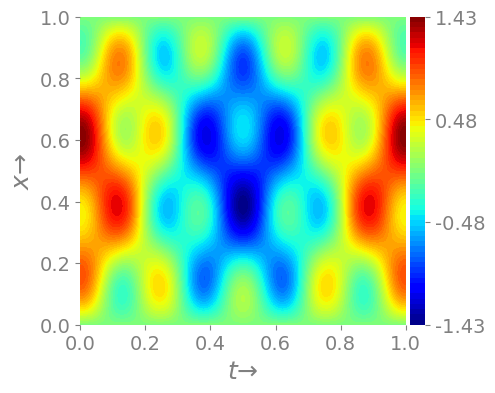

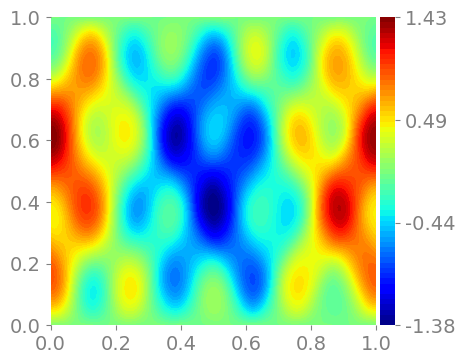

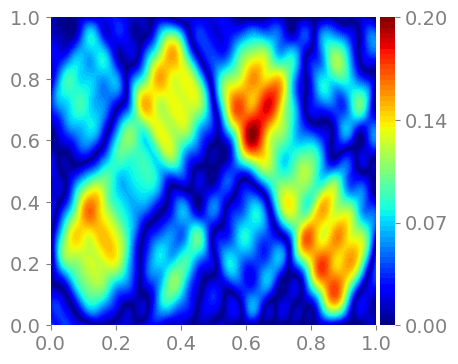

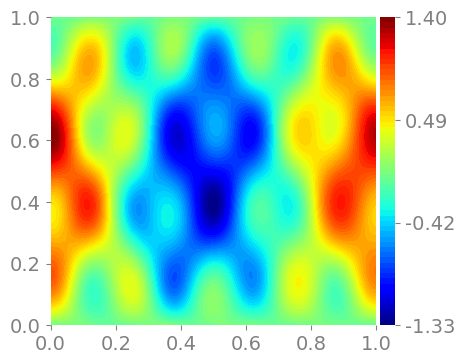

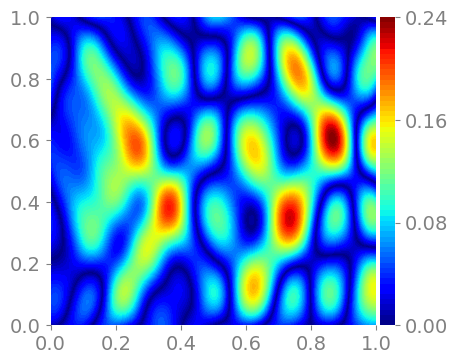

In [21]:
exact_veloctiy_wave = u
tanh_veloctiy_u_wave = u_pred_tanh
tanh_error_veloctiy_wave = np.abs(u_pred_tanh - u)
grbf_veloctiy_wave = u_pred_bspline
grbf_error_veloctiy_wave = np.abs(u_pred_bspline - u)

data = [
    exact_veloctiy_wave,
    tanh_veloctiy_u_wave,
    tanh_error_veloctiy_wave,
    grbf_veloctiy_wave,
    grbf_error_veloctiy_wave,
]

titles = [
    "exact_veloctiy_wave",
    "tanh_veloctiy_u_wave",
    "tanh_error_veloctiy_wave",
    "grbf_veloctiy_wave",
    "grbf_error_veloctiy_wave",
]
xy_labels = [r"$t→$", r"$x→$"]

for index, (title, z) in enumerate(zip(titles, data)):
    file_name = os.path.join(model_dirname, f"{title}.png")
    plot_xy = index == 0
    fig = plot_contour(
        X, z.reshape(NUMER_OF_POINTS, NUMER_OF_POINTS), file_name, plot_xy, xy_labels
    )